In [21]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [4]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [15]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG

In [8]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'dataset_summary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [9]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [10]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [16]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

## HT397B1

In [17]:
case = 'HT397B1'
z_scaler = .2
cluster_resolutions = [1., 1.5, 2.]
target_res = 50
visium_target_res = 100

In [18]:
# fix issues where antibody names aren't consistent accross some images
channel_to_idents = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
    'E-cadherin': ['E-cadherin', 'E-Cadherin'],
    'CD45': ['CD45'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin', 'Vim', 'VIM'],
    'SMA': ['SMA', 'a-SMA'],
    'CD31': ['CD31'],
    'CD20': ['CD20', 'CD20-Akoya'],
    'CD68': ['CD68'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
    'MGP': ['MGP'],
    'CD36': ['CD36'],
    'PR': ['PR'],
    'ER': ['ER'],
    'P21': ['P21'],
    'P16': ['P16'],
    'CK5': ['Keratin 5', 'KRT5', 'CK5'],
    'CK7': ['CK7'],
    'CK8/18': ['CK8/18'],
    'TFF1': ['TFF1'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'KRT14'],
    'CK17': ['CK17', 'Keratin 17', 'CK17'],
    'CK19': ['CK19', 'Keratin 19', 'KRT19'],
    'CD11b': ['CD11b', 'CD11B', 'cd11b'],
    'GATA3': ['GATA3'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
    'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
    'Her2': ['Her2', 'HER2'],
    'Bap1': ['Bap1', 'BAP1'],
    'GLUT1': ['Glut1', 'GLUT1'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR', 'HLADR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN'],
    'CTLA4': ['CTLA4'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3'],
    'PTPRZ1': ['PTPRZ1'],
    'HIF1A': ['HIF1a', 'HIF1A'],
    'PAI1': ['PAI1'],
    'GFAP': ['GFAP'],
    'VEGFA': ['VEGFA'],
    'IBA1': ['IBA1'],
    'OLIG2': ['OLIG2'],
    'FN1': ['FN1'],
    'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
    'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
    'Granzyme-B': ['Granzyme B', 'GZMB'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1', 'PD1'],
    'PDL1': ['PD-L1', 'PDL1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63', 'p63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1', 'LYVE1'],
    'CCL2': ['CCL2'],
    'MUC2': ['MUC2'],
    'SOX9': ['SOX9'],
    'STEAP4': ['STEAP4'],
    'AR': ['AR'],
    'AMACR': ['AMACR'],
    'PGC': ['PGC', 'PGC (D)'],
    'CFTR': ['CFTR (D)', 'CFTR'],
    'REG3A': ['REG3A (D)', 'REG3A'],
    'LAMC2': ['LAMC2 (D)', 'LAMC2'],
    'INS': ['INS (D)', 'INS'],
    'CRP': ['CRP (D)', 'CRP'],
    'CD74': ['CD74 (D)', 'CD74'],
    'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
    'AQP1': ['AQP1'],
    'AQP2': ['Aqp2', 'AQP2'], 
    'LRP2': ['LRP2'],
    'UMOD': ['UMOD'],
    'CALB1': ['CALB1'],
    'CP': ['CP'],
    'CA9': ['CA9'],
    'UCHL1': ['UCHL1'],
}
channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# add in (D) variants
variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
channel_mapping.update({k + variant:v
                      for k, v in channel_mapping.items()
                      for variant in variants})

In [19]:
dtype_to_weights = {
    'he': 0., # ignoring visium H&E
    'visium': 1.,
    'multiplex': 1.,
    'batch2_he': 1.
}

In [22]:
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

config = deepcopy(DEFAULT_CONFIG)

#         mask_fp = os.path.join(run_dir, case, 'masks', 'tissue_mask.tif')
#         if not os.path.exists(mask_fp):
#             mask_fp = None
mask_fp = None # running without masks

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': target_res,
        'out_dir': os.path.join('/data/estorrs/mushroom/data/projects/subclone', case, f'mushroom_{target_res}res'),
        'accelerator': 'gpu',
        'steps_per_epoch': 1000,
        'data_mask': mask_fp,
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': visium_target_res  # lower resolution for visium
        }
    },
    'multiplex': {
        'trainer_kwargs': {
            'channel_mapping': channel_mapping
        }
    }
})

config = alter_filesystem(config, source_root, target_root)
config

{'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_he.tif'}],
   'position': 0,
   'sid': 'HT397B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT397B1-U2'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he.tif'}],
   'position': 15,
   'sid': 'HT397B1-U4'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8_batch2_he.tif'}],
   'position': 35,
   'sid': 'HT397B1-U8'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/est

In [23]:
mushroom = Mushroom.from_config(config)

INFO:root:loading spore for batch2_he
INFO:root:data mask detected
INFO:root:starting batch2_he processing
INFO:root:6 sections detected: ['HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U4


0.007287140063108625


INFO:root:generating image data for section HT397B1-U8
INFO:root:generating image data for section HT397B1-U11
INFO:root:generating image data for section HT397B1-U16
INFO:root:generating image data for section HT397B1-U20
INFO:root:generating image data for section HT397B1-U28
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT397B1-U4', 'batch2_he'), ('HT397B1-U8', 'batch2_he'), ('HT397B1-U11', 'batch2_he'), ('HT397B1-U16', 'batch2_he'), ('HT397B1-U20', 'batch2_he'), ('HT397B1-U28', 'batch2_he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpj2qb4m4z
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpj2qb4m4z/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


batch2_he torch.Size([3, 135, 133])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U1


0.007287140063108625


INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 2 sections detected: [('HT397B1-U1', 'he'), ('HT397B1-U21', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 24 channels
INFO:root:4 sections detected: ['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U22', 'HT397B1-U31']
INFO:root:processing sections
INFO:root:generating image data for section HT397B1-U2


he torch.Size([3, 135, 133])
0.007287140063108625


INFO:root:generating image data for section HT397B1-U12
INFO:root:generating image data for section HT397B1-U22
INFO:root:generating image data for section HT397B1-U31
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 4 sections detected: [('HT397B1-U2', 'multiplex'), ('HT397B1-U12', 'multiplex'), ('HT397B1-U22', 'multiplex'), ('HT397B1-U31', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for visium
INFO:root:data mask detected
INFO:root:starting visium processing


multiplex torch.Size([24, 135, 133])


INFO:root:using 9675 channels
INFO:root:2 sections detected: ['HT397B1-U1', 'HT397B1-U21']
INFO:root:processing sections


ppm 0.36435700315543124 target_ppm 100
tiling size 274


INFO:root:generating image data for section HT397B1-U1
INFO:root:generating image data for section HT397B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset


visium torch.Size([9675, 69, 68])


INFO:root:total of 2 sections detected: [('HT397B1-U1', 'visium'), ('HT397B1-U21', 'visium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
mushroom.train()
mushroom.embed_sections()

INFO:root:starting training for batch2_he
Missing logger folder: /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/batch2_he_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.870    Total estimated model params size (MB)
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training batch2_he, saved chkpt to /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/batch2_he_chkpts/last.ckpt
INFO:root:starting training for he
Missing logger folder: /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/he_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.868    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/he_chkpts/last.ckpt
INFO:root:starting training for multiplex
Missing logger folder: /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/multiplex_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.914    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/multiplex_chkpts/last.ckpt
INFO:root:starting training for visium
Missing logger folder: /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/visium_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 27.2 M
------------------------------
27.2 M    Trainable params
0         Non-trainable params
27.2 M    Total params
108.709   Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training visium, saved chkpt to /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res/visium_chkpts/last.ckpt
INFO:root:embedding batch2_he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding visium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

batch2_he 0


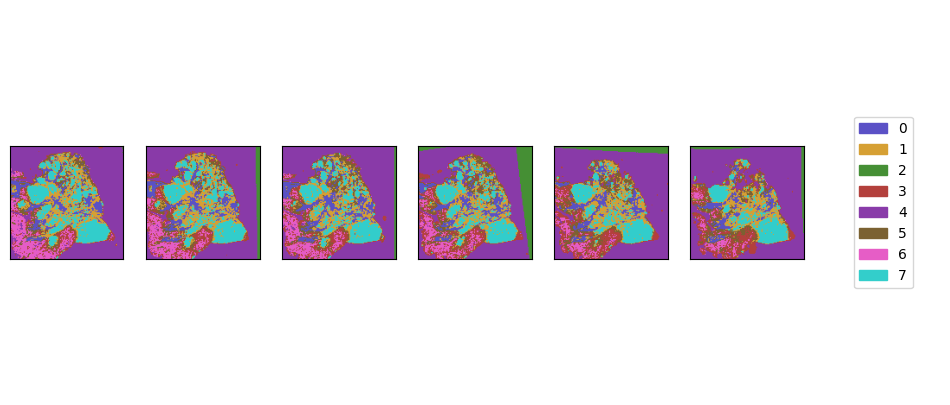

batch2_he 1


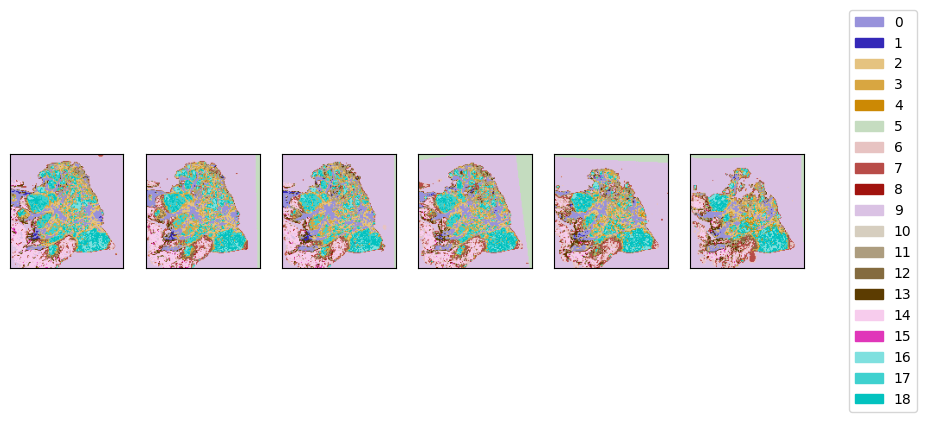

batch2_he 2


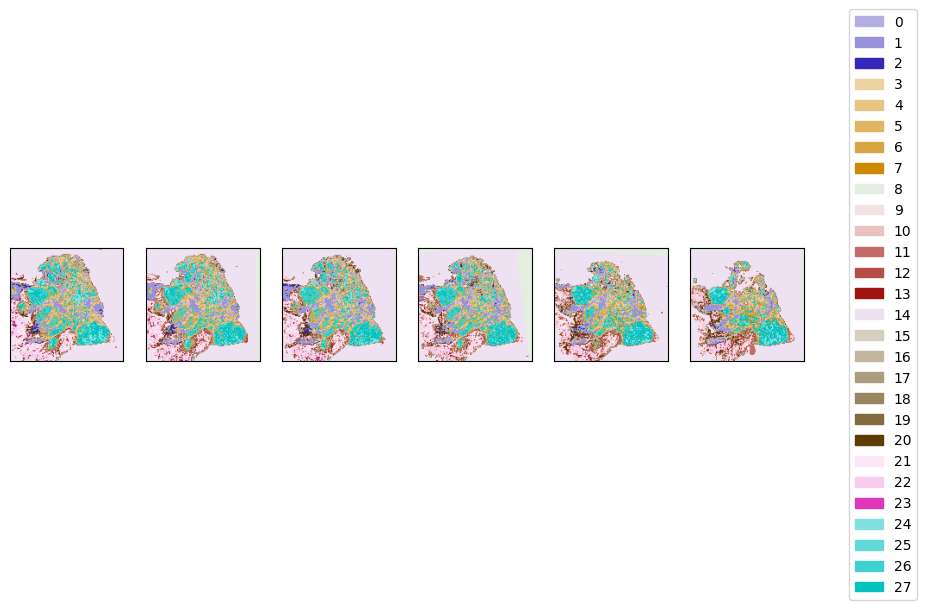

he 0


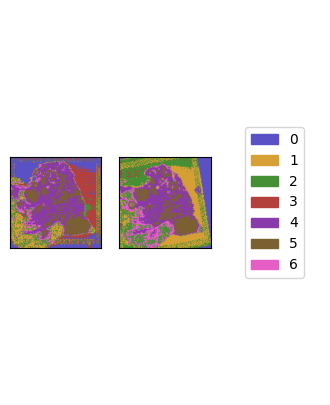

he 1


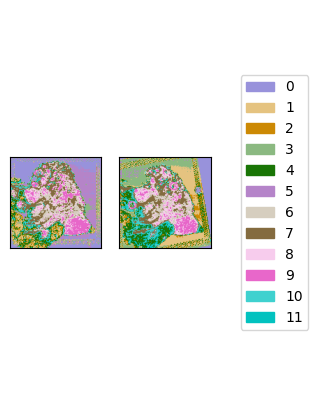

he 2


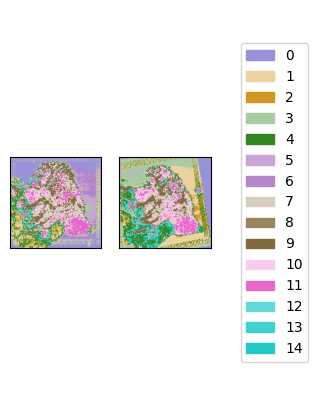

multiplex 0


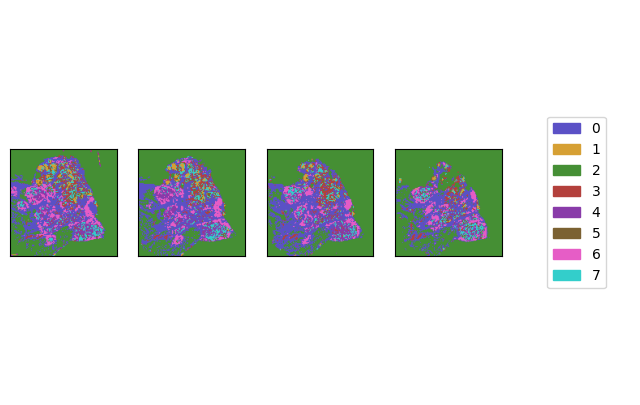

multiplex 1


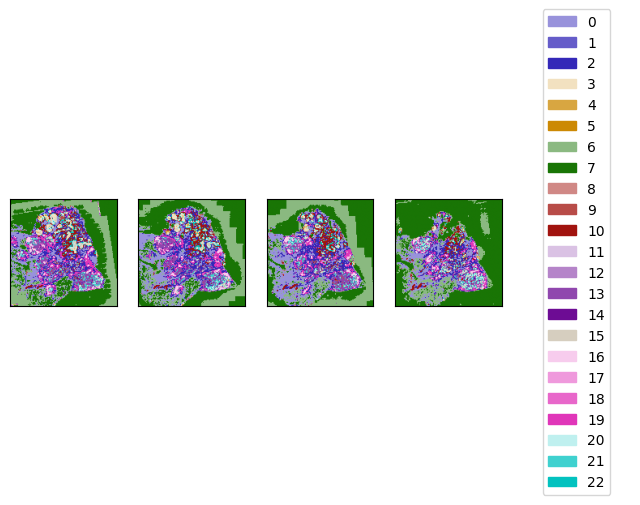

multiplex 2


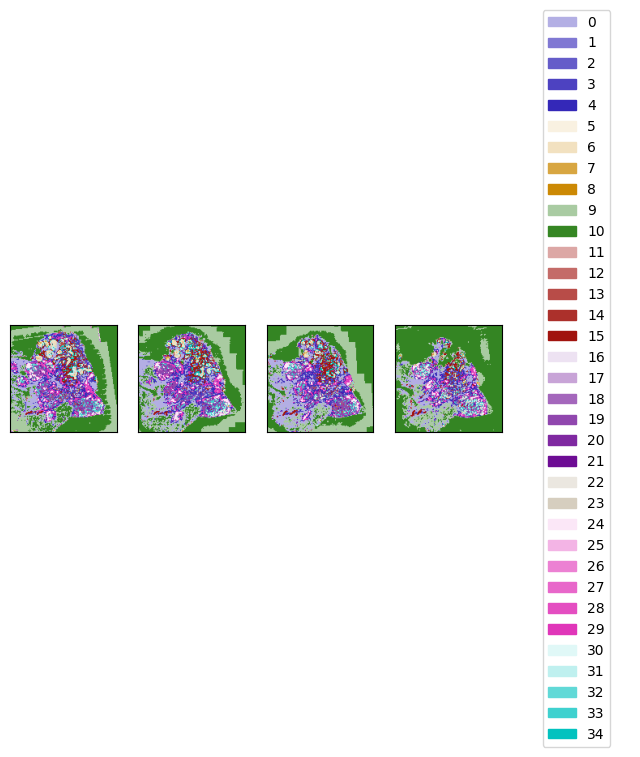

visium 0


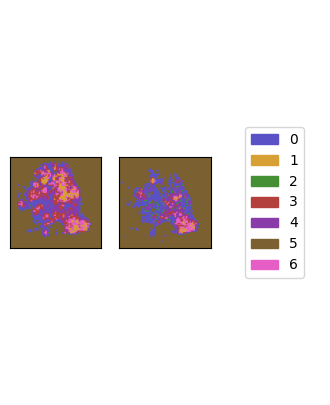

visium 1


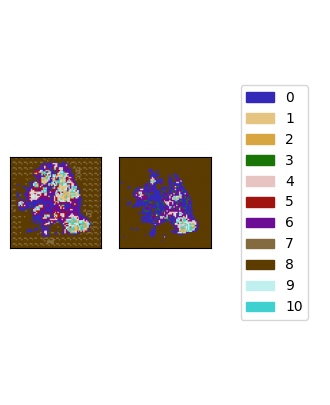

visium 2


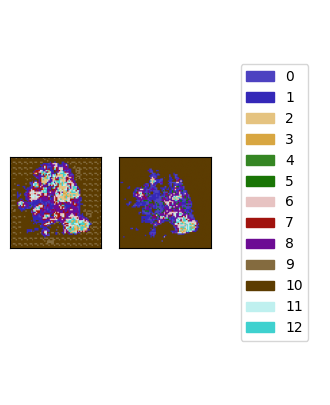

In [26]:
for dtype in mushroom.dtypes:
    for level in range(mushroom.num_levels):
        print(dtype, level)
        mushroom.display_clusters(dtype, level=level)
        plt.show()

In [27]:
out_dir = mushroom.trainer_kwargs['out_dir']

INFO:root:generating volume for batch2_he spore


0


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:dtypes ['he'] have a weight of zero, excluding.
INFO:root:merging cluster volumes
INFO:root:constructing graph with 80656 edges
INFO:root:1700 edges remaining after filtering
INFO:root:284 of 284 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 17 clusters


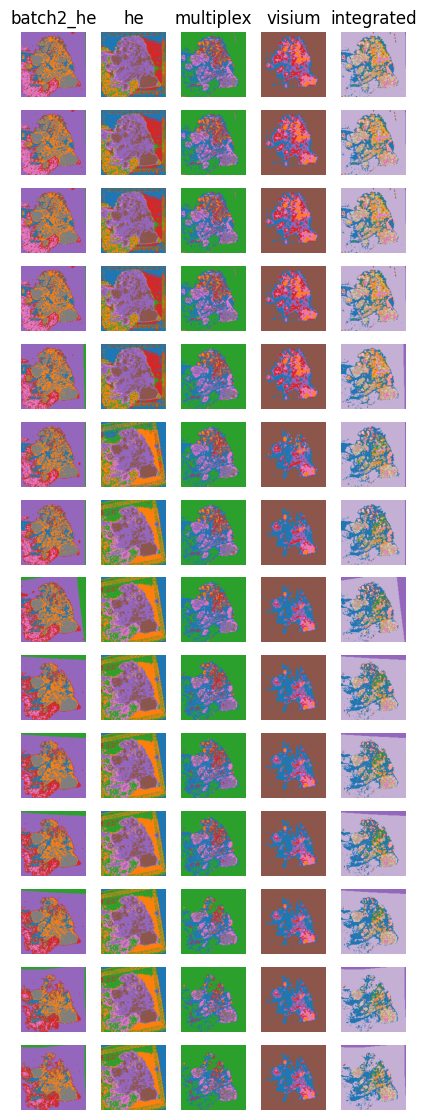

INFO:root:generating volume for batch2_he spore


1


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:dtypes ['he'] have a weight of zero, excluding.
INFO:root:merging cluster volumes
INFO:root:constructing graph with 2446096 edges
INFO:root:25610 edges remaining after filtering
INFO:root:1564 of 1564 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 16 clusters


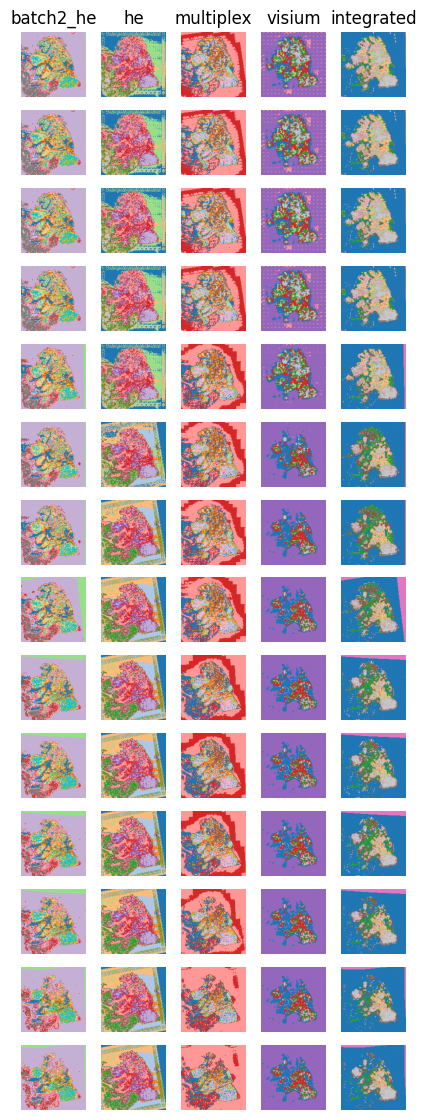

INFO:root:generating volume for batch2_he spore


2


INFO:root:generating volume for he spore
INFO:root:generating volume for multiplex spore
INFO:root:generating volume for visium spore
INFO:root:generating integrated volume
INFO:root:dtypes ['he'] have a weight of zero, excluding.
INFO:root:merging cluster volumes
INFO:root:constructing graph with 9572836 edges
INFO:root:93280 edges remaining after filtering
INFO:root:3094 of 3094 nodes processed
INFO:root:starting leiden clustering
INFO:root:finished integration, found 20 clusters


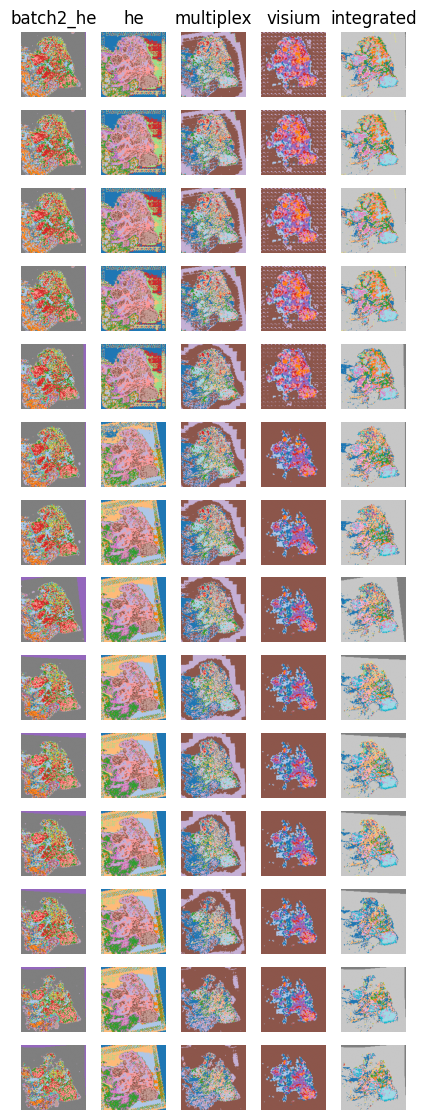

In [28]:
for level, cluster_res in enumerate(cluster_resolutions):
    print(level)
    dtype_to_volume = mushroom.generate_interpolated_volumes(
        z_scaler=z_scaler, level=level, integrate=True, dtype_to_weight=dtype_to_weights, resolution=cluster_res)
    dtype_to_volume_labels = {k:v.argmax(-1) if k != 'integrated' else v for k, v in dtype_to_volume.items()}

    mushroom.display_volumes(dtype_to_volume=dtype_to_volume_labels, positions=mushroom.section_positions)
    plt.show()

    pickle.dump({
        'probs': dtype_to_volume,
        'labeled': dtype_to_volume_labels
    }, open(os.path.join(out_dir, f'nbhd_volumes_l{level}.pkl'), 'wb'), protocol=4)

    del(dtype_to_volume)
    del(dtype_to_volume_labels)

In [30]:
clustering_params = {
    'z_scaler': z_scaler,
    'cluster_resolutions': cluster_resolutions,
    'dtype_to_weight': dtype_to_weights
}
yaml.safe_dump(clustering_params, open(os.path.join(out_dir, 'nbhd_volume_params.yaml'), 'w'))

In [31]:
mushroom.save()

INFO:root:saving config and outputs to /data/estorrs/mushroom/data/projects/subclone/HT397B1/mushroom_50res


In [25]:
# mushroom = Mushroom.from_config(os.path.join(project_dir, 'HT397B1', 'mushroom_50res'))

In [32]:
volume = pickle.load(
    open(os.path.join(mushroom.trainer_kwargs['out_dir'], f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled']['integrated']

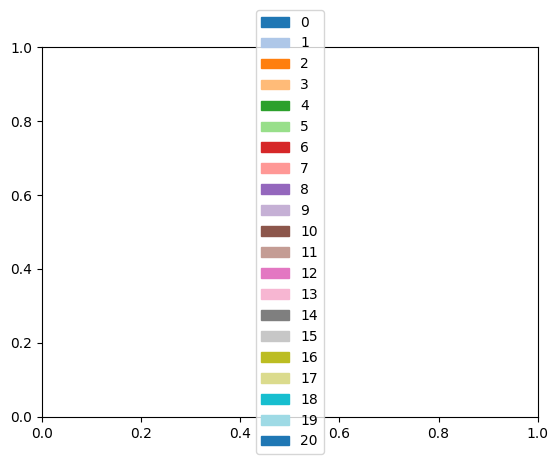

In [92]:
vis_utils.display_legend(np.unique(volume), vis_utils.get_cmap(len(np.unique(volume))))

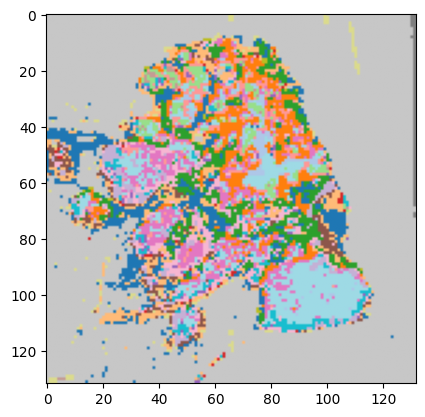

In [33]:
rgb = vis_utils.display_labeled_as_rgb(volume[0])
plt.imshow(rgb)

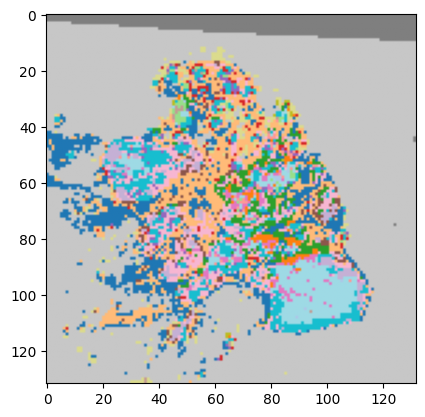

In [35]:
rgb = vis_utils.display_labeled_as_rgb(volume[20])
plt.imshow(rgb)

In [36]:
!cat /data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml

- data:
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad
  id: s0
  position: 0
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff
  id: s1
  position: 5
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff
  id: s2
  position: 55
- data:
  - dtype: he
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad
  - dtype: visium
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad
  id: s3
  position: 100
- data:
  - dtype: multiplex
    filepath: /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s4_multiplex.ome.tiff
  id: s4
  position: 105
- data:
  - dt

In [49]:
config = yaml.safe_load(open('/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'))
sid_to_adata = {
    ('HT397B1-U1', 'visium'): sc.read_h5ad('/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad'),
    ('HT397B1-U21', 'visium'): sc.read_h5ad('/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad'),
}

In [48]:
# case_to_exp = {}
# for case in case_order:
#     print(case)
#     dtype_to_true_pixels = pickle.load(
#         open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
#     )
    
#     dtypes = [dt for dt in dtype_to_true_pixels.keys() if dt != 'integrated']
#     dtype_to_exp = {}
#     for dtype in dtypes:    
#         channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
#         true_pixels = np.stack(true_pixels)

#         volume = pickle.load(
#             open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
#         )['labeled']['integrated']

#         outputs = pickle.load(
#             open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
#         )
#         section_ids = outputs['section_ids']
#         section_positions = outputs['section_positions']
#         positions = [i for i, (sid, dt) in zip(section_positions, section_ids) if dt==dtype]
#         volume = volume[positions]

#         data = []
#         for label in np.unique(volume):
#             data.append(true_pixels[volume==label].mean(0))
#         exp_df = pd.DataFrame(data=data, columns=channels, index=np.unique(volume))
#         dtype_to_exp[dtype] = exp_df
    
#     case_to_exp[case] = dtype_to_exp
    
    

In [66]:
for (sid, dtype), a in sid_to_adata.items():
    pts = a.obsm['spatial']
    labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=-1, volume=volume, use_volume=True)
    a.obs['nbhd'] = [f'nbhd {l}' for l in labels]
    a.obs['annotation'] = [sub if 'clone' in sub else nbhd
                           for sub, nbhd in zip(a.obs['subclone'], a.obs['nbhd'])]


In [67]:
# harmonize

In [68]:
a.obs

in_tissue  array_row  array_col  FC1    FC2  \
HT397B1-U21_AAACAGAGCGACTCCT-1          1         14         94  3.0  402.0   
HT397B1-U21_AAACAGCTTTCAGAAG-1          1         43          9  0.0    0.0   
HT397B1-U21_AAACAGTGTTCCTGGG-1          1         73         43  0.0    0.0   
HT397B1-U21_AAACCGGGTAGGTACC-1          1         42         28  0.0    0.0   
HT397B1-U21_AAACCGTTCGTCCAGG-1          1         52         42  2.0  232.0   
...                                   ...        ...        ...  ...    ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1          1         24         64  0.0    0.0   
HT397B1-U21_TTGTTGTGTGTCAAGA-1          1         31         77  0.0    0.0   
HT397B1-U21_TTGTTTCACATCCAGG-1          1         58         42  1.0  232.0   
HT397B1-U21_TTGTTTCATTAGTCTA-1          1         60         30  0.0    0.0   
HT397B1-U21_TTGTTTGTATTACACG-1          1         73         41  0.0    0.0   

                                FC3    FC4  FC5    FC6  \
HT397B1-U21_AAACAGAGCGACTCCT-1  3.0  402.0  3.0  402.0   
HT397B1-U21_AAACAGCTTTCAGAAG-1  0.0    0.0  0.0    0.0   
HT397B1-U21_AAACAGTGTTCCTGGG-1  0.0    0.0  0.0    0.0   
HT397B1-U21_AAACCGGGTAGGTACC-1  0.0    0.0  0.0    0.0   
HT397B1-U21_AAACCGTTCGTCCAGG-1  2.0  232.0  2.0  232.0   
...                             ...    ...  ...    ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1  0.0    0.0  0.0    0.0   
HT397B1-U21_TTGTTGTGTGTCAAGA-1  0.0    0.0  0.0    0.0   
HT397B1-U21_TTGTTTCACATCCAGG-1  1.0  232.0  1.0  232.0   
HT397B1-U21_TTGTTTCATTAGTCTA-1  0.0    0.0  0.0    0.0   
HT397B1-U21_TTGTTTGTATTACACG-1  0.0    0.0  0.0    0.0   

                                Filtered tumor regions  ...  Tumor boundary  \
HT397B1-U21_AAACAGAGCGACTCCT-1                     1.0  ...             NaN   
HT397B1-U21_AAACAGCTTTCAGAAG-1                     0.0  ...             NaN   
HT397B1-U21_AAACAGTGTTCCTGGG-1                     0.0  ...             NaN   
HT397B1-U21_AAACCGGGTAGGTACC-1                     0.0  ...             NaN   
HT397B1-U21_AAACCGTTCGTCCAGG-1                     2.0  ...             NaN   
...                                                ...  ...             ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTGTGTGTCAAGA-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTTCACATCCAGG-1                     2.0  ...  Tumor boundary   
HT397B1-U21_TTGTTTCATTAGTCTA-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTTGTATTACACG-1                     0.0  ...             NaN   

                               Tumor regions  Tumor vs. TME  \
HT397B1-U21_AAACAGAGCGACTCCT-1           1.0            TME   
HT397B1-U21_AAACAGCTTTCAGAAG-1           0.0            TME   
HT397B1-U21_AAACAGTGTTCCTGGG-1           0.0            TME   
HT397B1-U21_AAACCGGGTAGGTACC-1           0.0            TME   
HT397B1-U21_AAACCGTTCGTCCAGG-1           2.0            TME   
...                                      ...            ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1           0.0            TME   
HT397B1-U21_TTGTTGTGTGTCAAGA-1           0.0            TME   
HT397B1-U21_TTGTTTCACATCCAGG-1           2.0            TME   
HT397B1-U21_TTGTTTCATTAGTCTA-1           0.0            TME   
HT397B1-U21_TTGTTTGTATTACACG-1           0.0            TME   

                                           barcode            library_id  \
HT397B1-U21_AAACAGAGCGACTCCT-1  AAACAGAGCGACTCCT-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_AAACAGCTTTCAGAAG-1  AAACAGCTTTCAGAAG-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_AAACAGTGTTCCTGGG-1  AAACAGTGTTCCTGGG-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_AAACCGGGTAGGTACC-1  AAACCGGGTAGGTACC-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_AAACCGTTCGTCCAGG-1  AAACCGTTCGTCCAGG-1  HT397B1-S1H3A1U21Bp1   
...                                            ...                   ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1  TTGTTCAGTGTGCTAC-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_TTGTTGTGTGTCAAGA-1  TTGTTGTGTGTCAAGA-1  HT397B1-S1H3A1U21Bp1

... storing 'nbhd' as categorical
... storing 'annotation' as categorical


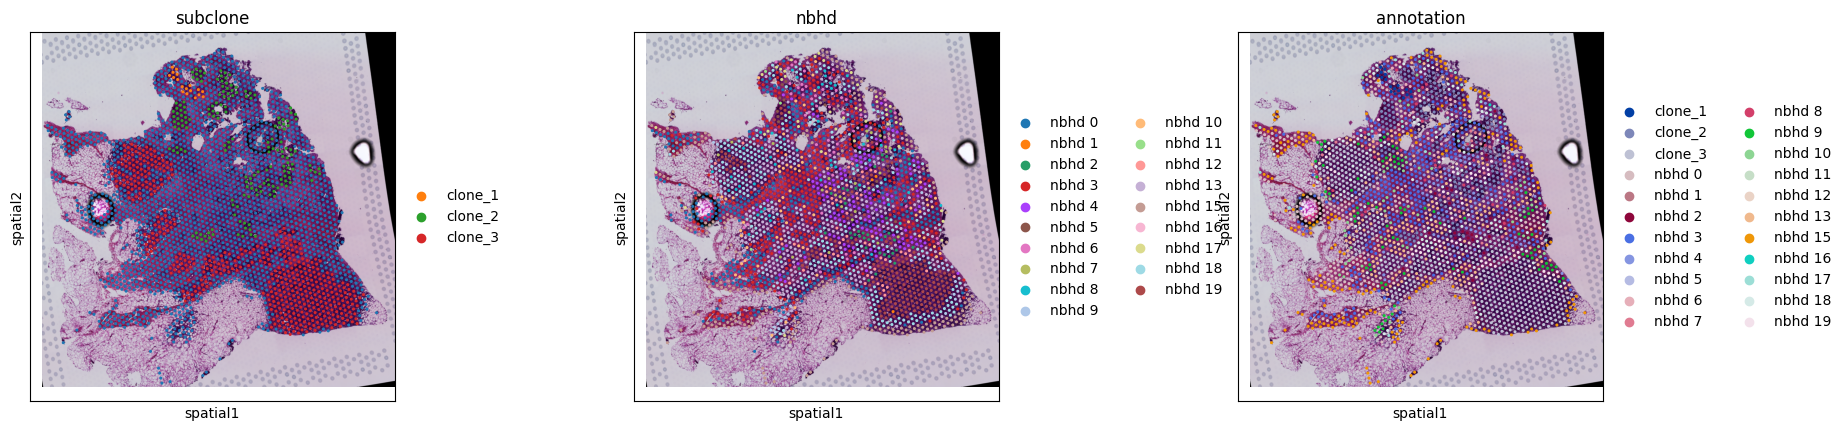

In [69]:
sc.pl.spatial(a, color=['subclone', 'nbhd', 'annotation'])

In [155]:
import anndata
combined = anndata.concat(sid_to_adata.values())
combined.obs

in_tissue  array_row  array_col  FC1    FC2  \
HT397B1-U1_AAACAAGTATCTCCCA-1           1         50        102  0.0    0.0   
HT397B1-U1_AAACACCAATAACTGC-1           1         59         19  1.0  232.0   
HT397B1-U1_AAACAGAGCGACTCCT-1           1         14         94  0.0    0.0   
HT397B1-U1_AAACAGCTTTCAGAAG-1           1         43          9  0.0    0.0   
HT397B1-U1_AAACAGGGTCTATATT-1           1         47         13  1.0  232.0   
...                                   ...        ...        ...  ...    ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1          1         24         64  0.0    0.0   
HT397B1-U21_TTGTTGTGTGTCAAGA-1          1         31         77  0.0    0.0   
HT397B1-U21_TTGTTTCACATCCAGG-1          1         58         42  1.0  232.0   
HT397B1-U21_TTGTTTCATTAGTCTA-1          1         60         30  0.0    0.0   
HT397B1-U21_TTGTTTGTATTACACG-1          1         73         41  0.0    0.0   

                                FC3    FC4      FC5    FC6  \
HT397B1-U1_AAACAAGTATCTCCCA-1   0.0    0.0      0.0    0.0   
HT397B1-U1_AAACACCAATAACTGC-1   1.0  232.0      1.0  232.0   
HT397B1-U1_AAACAGAGCGACTCCT-1   0.0    0.0      0.0    0.0   
HT397B1-U1_AAACAGCTTTCAGAAG-1   0.0    0.0      0.0    0.0   
HT397B1-U1_AAACAGGGTCTATATT-1   0.0    0.0  unknown    0.0   
...                             ...    ...      ...    ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1  0.0    0.0      0.0    0.0   
HT397B1-U21_TTGTTGTGTGTCAAGA-1  0.0    0.0      0.0    0.0   
HT397B1-U21_TTGTTTCACATCCAGG-1  1.0  232.0      1.0  232.0   
HT397B1-U21_TTGTTTCATTAGTCTA-1  0.0    0.0      0.0    0.0   
HT397B1-U21_TTGTTTGTATTACACG-1  0.0    0.0      0.0    0.0   

                                Filtered tumor regions  ...  Tumor boundary  \
HT397B1-U1_AAACAAGTATCTCCCA-1                      0.0  ...             NaN   
HT397B1-U1_AAACACCAATAACTGC-1                     33.0  ...  Tumor boundary   
HT397B1-U1_AAACAGAGCGACTCCT-1                      0.0  ...             NaN   
HT397B1-U1_AAACAGCTTTCAGAAG-1                      0.0  ...             NaN   
HT397B1-U1_AAACAGGGTCTATATT-1                      1.0  ...             NaN   
...                                                ...  ...             ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTGTGTGTCAAGA-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTTCACATCCAGG-1                     2.0  ...  Tumor boundary   
HT397B1-U21_TTGTTTCATTAGTCTA-1                     0.0  ...             NaN   
HT397B1-U21_TTGTTTGTATTACACG-1                     0.0  ...             NaN   

                               Tumor regions  Tumor vs. TME  \
HT397B1-U1_AAACAAGTATCTCCCA-1            0.0            TME   
HT397B1-U1_AAACACCAATAACTGC-1           33.0          Tumor   
HT397B1-U1_AAACAGAGCGACTCCT-1            0.0            TME   
HT397B1-U1_AAACAGCTTTCAGAAG-1            0.0            TME   
HT397B1-U1_AAACAGGGTCTATATT-1            1.0          Tumor   
...                                      ...            ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1           0.0            TME   
HT397B1-U21_TTGTTGTGTGTCAAGA-1           0.0            TME   
HT397B1-U21_TTGTTTCACATCCAGG-1           2.0            TME   
HT397B1-U21_TTGTTTCATTAGTCTA-1           0.0            TME   
HT397B1-U21_TTGTTTGTATTACACG-1           0.0            TME   

                                           barcode            library_id  \
HT397B1-U1_AAACAAGTATCTCCCA-1   AAACAAGTATCTCCCA-1   HT397B1-S1H3A1U1Bp1   
HT397B1-U1_AAACACCAATAACTGC-1   AAACACCAATAACTGC-1   HT397B1-S1H3A1U1Bp1   
HT397B1-U1_AAACAGAGCGACTCCT-1   AAACAGAGCGACTCCT-1   HT397B1-S1H3A1U1Bp1   
HT397B1-U1_AAACAGCTTTCAGAAG-1   AAACAGCTTTCAGAAG-1   HT397B1-S1H3A1U1Bp1   
HT397B1-U1_AAACAGGGTCTATATT-1   AAACAGGGTCTATATT-1   HT397B1-S1H3A1U1Bp1   
...                                            ...                   ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1  TTGTTCAGTGTGCTAC-1  HT397B1-S1H3A1U21Bp1   
HT397B1-U21_TTGTTGTGTGTC

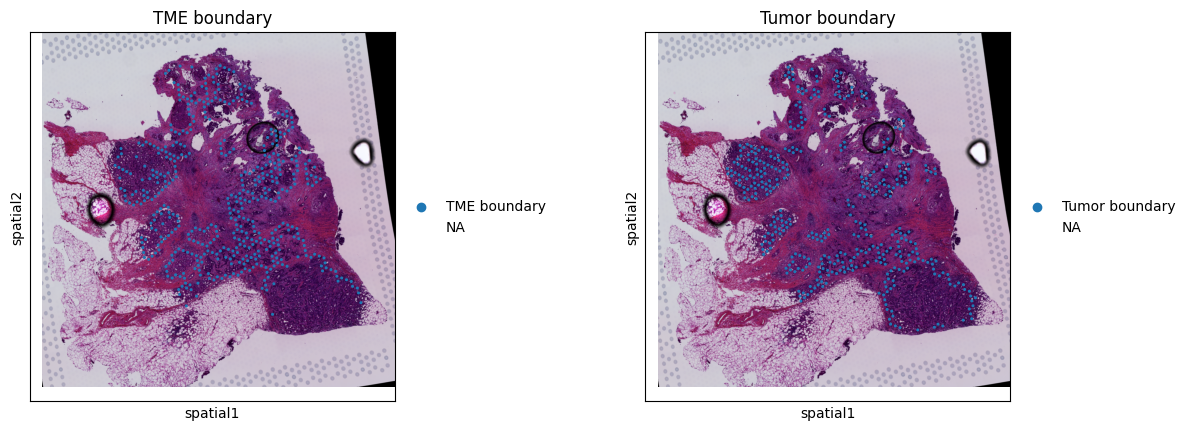

In [132]:
sc.pl.spatial(a, color=['TME boundary', 'Tumor boundary'])

In [199]:
boundary = combined[pd.isnull(combined.obs[['TME boundary', 'Tumor boundary']]).sum(1) < 2]
boundary

View of AnnData object with n_obs × n_vars = 1972 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Filtered tumor regions', 'Filtered tumor regions auto', 'Filtered tumor vs. TME', 'Manual annotation', 'Morphologically processed purity', 'Purity', 'TME before boundary', 'TME boundary', 'Tumor before boundary', 'Tumor boundary', 'Tumor regions', 'Tumor vs. TME', 'barcode', 'library_id', 'original', 'sample_id', 'subclone', 'nbhd', 'annotation'
    obsm: 'spatial'

In [204]:
counts = Counter(boundary.obs['nbhd'])
keep = [k for k, v in counts.items() if v > 10]
keep

['nbhd 7',
 'nbhd 3',
 'nbhd 19',
 'nbhd 15',
 'nbhd 1',
 'nbhd 12',
 'nbhd 9',
 'nbhd 0',
 'nbhd 13',
 'nbhd 4',
 'nbhd 18',
 'nbhd 10',
 'nbhd 2',
 'nbhd 5',
 'nbhd 8',
 'nbhd 17',
 'nbhd 6']

In [211]:
mask = np.asarray([False] * f.shape[0])
mask[:10] = True

f[mask]

View of AnnData object with n_obs × n_vars = 10 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Filtered tumor regions', 'Filtered tumor regions auto', 'Filtered tumor vs. TME', 'Manual annotation', 'Morphologically processed purity', 'Purity', 'TME before boundary', 'TME boundary', 'Tumor before boundary', 'Tumor boundary', 'Tumor regions', 'Tumor vs. TME', 'barcode', 'library_id', 'original', 'sample_id', 'subclone', 'nbhd', 'annotation'
    uns: 'dendrogram_nbhd'
    obsm: 'spatial', 'X_pca'

(924, 17943)
         Falling back to preprocessing with `sc.pp.pca` and default params.


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/tools/_utils.py:46: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X
... storing 'barcode' as categorical
... storing 'annotation' as categorical
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


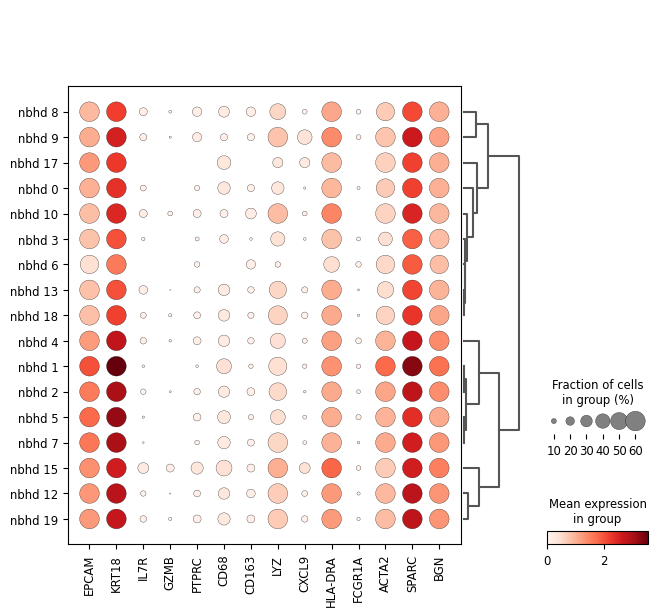

In [217]:
f = boundary.copy()
f.obs['nbhd'] = f.obs['nbhd'].astype('category')
# print(len([True if k in keep else False for k in f.obs['nbhd']]))
f = f[np.asarray([True if k in keep else False for k in f.obs['nbhd']])]
print(f.shape)
sc.tl.dendrogram(f, groupby='nbhd')
sc.pl.dotplot(
    f,
    groupby='nbhd', var_names=genes, dendrogram=True, dot_max=.6, log=True)
#     save='expression.pdf')

# sc.pl.dotplot(
#     f,
#     groupby='nbhd', var_names=genes, categories_order=order, dendrogram=False, dot_max=.6, log=True)

In [180]:
f = combined.obs[[True if 'clone' in x else False for x in combined.obs['subclone']]]
clone_overlap = Counter(f['nbhd'])
total_counts = Counter(combined.obs['nbhd'])

exclude = []
for c, v in clone_overlap.items():
    if v / total_counts[c] > .5:
        exclude.append(c)
    print(c, v, v / total_counts[c])
exclude

nbhd 3 96 0.15483870967741936
nbhd 5 55 0.5238095238095238
nbhd 7 77 0.4010416666666667
nbhd 18 189 0.4666666666666667
nbhd 12 98 0.29878048780487804
nbhd 19 424 0.6300148588410104
nbhd 1 32 0.43243243243243246
nbhd 4 62 0.13747228381374724
nbhd 0 75 0.11467889908256881
nbhd 9 49 0.23444976076555024
nbhd 13 140 0.2723735408560311
nbhd 6 19 0.2878787878787879
nbhd 2 89 0.25
nbhd 17 11 0.18333333333333332
nbhd 10 14 0.0979020979020979
nbhd 15 68 0.1261595547309833
nbhd 11 9 0.6428571428571429
nbhd 8 35 0.40229885057471265


['nbhd 5', 'nbhd 19', 'nbhd 11']

In [181]:
from collections import Counter

clone_to_counts = {}
data = []
order = [k for k in sorted(set(combined.obs['nbhd'])) if k not in exclude]
clones = [c for c in sorted(set(boundary.obs['subclone'])) if c]
for clone in clones:
    mask = boundary.obs['subclone']==clone
    n = np.count_nonzero(mask)
    cs = Counter(boundary.obs[mask]['nbhd'])
    d = {k:cs[k] / n for k in order}
    data.append([d.get(k, 0) for k in order])
df = pd.DataFrame(data, index=clones, columns=order).T
df.sort_values('clone_3')

clone_1   clone_2   clone_3
nbhd 16  0.000000  0.000000  0.000000
nbhd 20  0.000000  0.000000  0.000000
nbhd 1   0.000000  0.070288  0.003610
nbhd 6   0.048387  0.003195  0.009025
nbhd 17  0.048387  0.000000  0.009025
nbhd 10  0.000000  0.003195  0.018051
nbhd 7   0.112903  0.089457  0.019856
nbhd 8   0.016129  0.019169  0.027076
nbhd 2   0.177419  0.146965  0.028881
nbhd 4   0.000000  0.105431  0.032491
nbhd 15  0.000000  0.009585  0.034296
nbhd 0   0.096774  0.083067  0.046931
nbhd 9   0.016129  0.003195  0.054152
nbhd 3   0.096774  0.092652  0.061372
nbhd 12  0.032258  0.073482  0.090253
nbhd 13  0.016129  0.076677  0.151625
nbhd 18  0.048387  0.051118  0.160650

In [183]:
df.sort_values('clone_1')

clone_1   clone_2   clone_3
nbhd 1   0.000000  0.070288  0.003610
nbhd 10  0.000000  0.003195  0.018051
nbhd 15  0.000000  0.009585  0.034296
nbhd 16  0.000000  0.000000  0.000000
nbhd 4   0.000000  0.105431  0.032491
nbhd 20  0.000000  0.000000  0.000000
nbhd 9   0.016129  0.003195  0.054152
nbhd 13  0.016129  0.076677  0.151625
nbhd 8   0.016129  0.019169  0.027076
nbhd 12  0.032258  0.073482  0.090253
nbhd 6   0.048387  0.003195  0.009025
nbhd 18  0.048387  0.051118  0.160650
nbhd 17  0.048387  0.000000  0.009025
nbhd 3   0.096774  0.092652  0.061372
nbhd 0   0.096774  0.083067  0.046931
nbhd 7   0.112903  0.089457  0.019856
nbhd 2   0.177419  0.146965  0.028881

In [213]:
boundary = boundary[boundary.obs['Tumor boundary']=='Tumor boundary']
boundary

View of AnnData object with n_obs × n_vars = 929 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Filtered tumor regions', 'Filtered tumor regions auto', 'Filtered tumor vs. TME', 'Manual annotation', 'Morphologically processed purity', 'Purity', 'TME before boundary', 'TME boundary', 'Tumor before boundary', 'Tumor boundary', 'Tumor regions', 'Tumor vs. TME', 'barcode', 'library_id', 'original', 'sample_id', 'subclone', 'nbhd', 'annotation'
    obsm: 'spatial'

In [214]:
from collections import Counter

clone_to_counts = {}
data = []
order = [k for k in sorted(set(boundary.obs['nbhd'])) if k not in exclude]
clones = [c for c in sorted(set(boundary.obs['subclone'])) if c]
total_counts = Counter(boundary.obs['nbhd'])
for clone in clones:
    mask = boundary.obs['subclone']==clone
    n = np.count_nonzero(mask)
    cs = Counter(boundary.obs[mask]['nbhd'])
    d = {k:cs[k] / total_counts[k] for k in order}
    data.append([d.get(k, 0) for k in order])
df = pd.DataFrame(data, index=clones, columns=order).T
df.sort_values('clone_3', ascending=False)

clone_1   clone_2   clone_3
nbhd 9   0.031250  0.031250  0.937500
nbhd 10  0.000000  0.090909  0.909091
nbhd 15  0.000000  0.136364  0.863636
nbhd 18  0.027778  0.148148  0.824074
nbhd 13  0.009174  0.220183  0.770642
nbhd 8   0.045455  0.272727  0.681818
nbhd 12  0.026667  0.306667  0.666667
nbhd 17  0.375000  0.000000  0.625000
nbhd 6   0.333333  0.111111  0.555556
nbhd 3   0.086957  0.420290  0.492754
nbhd 0   0.103448  0.448276  0.448276
nbhd 4   0.000000  0.647059  0.352941
nbhd 7   0.152174  0.608696  0.239130
nbhd 2   0.150685  0.630137  0.219178
nbhd 1   0.000000  0.916667  0.083333

In [215]:
order = df.index.to_list()

In [219]:
f = combined.copy()
f.obs['annotation'] = f.obs['annotation'].astype('category')
sc.tl.dendrogram(f, groupby='annotation')
sc.pl.dotplot(
    f,
    groupby='annotation', var_names=genes, dendrogram=False, dot_max=.6, log=True, categories_order=order)
#     save='expression.pdf')

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'barcode' as categorical
... storing 'nbhd' as categorical


ERROR: Please check that the categories given by the `order` parameter match the categories that want to be reordered.

Mismatch: {'nbhd 19', 'nbhd 5', 'clone_3', 'clone_2', 'clone_1', 'nbhd 16', 'nbhd 11', 'nbhd 20'}

Given order categories: ['nbhd 0', 'nbhd 1', 'nbhd 10', 'nbhd 12', 'nbhd 13', 'nbhd 15', 'nbhd 17', 'nbhd 18', 'nbhd 2', 'nbhd 3', 'nbhd 4', 'nbhd 6', 'nbhd 7', 'nbhd 8', 'nbhd 9']

annotation categories: ['clone_1', 'clone_2', 'clone_3', 'nbhd 0', 'nbhd 1', 'nbhd 10', 'nbhd 11', 'nbhd 12', 'nbhd 13', 'nbhd 15', 'nbhd 16', 'nbhd 17', 'nbhd 18', 'nbhd 19', 'nbhd 2', 'nbhd 20', 'nbhd 3', 'nbhd 4', 'nbhd 5', 'nbhd 6', 'nbhd 7', 'nbhd 8', 'nbhd 9']



AttributeError: 'DotPlot' object has no attribute 'group_extra_size'

In [129]:
def get_nbhd_rgb(labeled, nbhds):
    rgb = vis_utils.display_labeled_as_rgb(labeled)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

# def get_intensity_img(case, dtype, gene):
#     dtype_to_true_pixels = pickle.load(
#         open(os.path.join(project_dir, case, 'mushroom_50res', 'true_pixels.pkl'), 'rb')
#     )
    
#     channels, true_pixels = dtype_to_true_pixels[dtype]['channels'], dtype_to_true_pixels[dtype]['true_pixels']
#     true_pixels = true_pixels[0]
    
#     img = true_pixels[..., channels.index(gene)]
    
#     return img


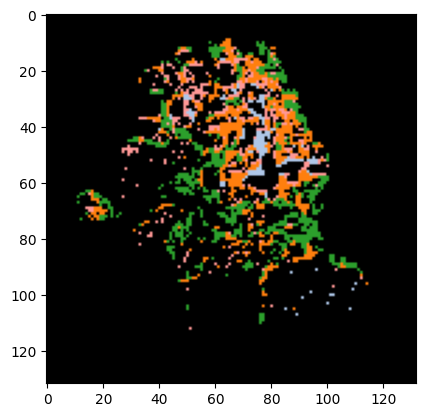

In [197]:
# 18, 12, 9
rgb = get_nbhd_rgb(volume[0], [1,2,7,4])
plt.imshow(rgb)

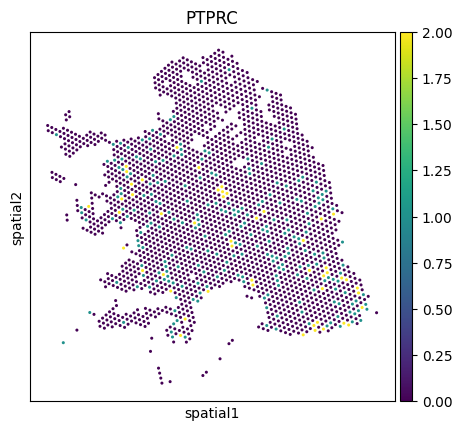

In [105]:
sc.pl.spatial(a, color=['PTPRC'], alpha_img=0, vmax=2.)

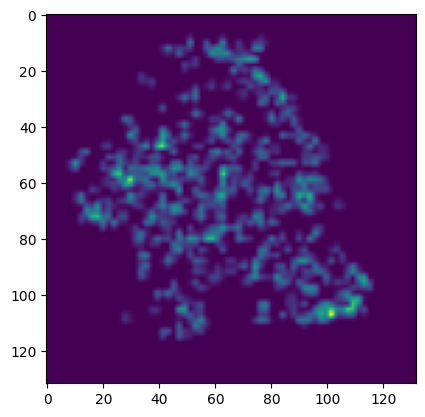

In [106]:
channels = mushroom.dtype_to_spore['visium'].learner_data.dtype_to_channels['visium']
img = mushroom.dtype_to_spore['visium'].true_pixels[0][..., channels.index('PTPRC')]
plt.imshow(img)

In [120]:
components = {
    'Fibroblast': ['ACTA2', 'COL17A1', 'MYH11', 'CNN1'],
    'T cell': ['CD3D', 'CD3E', 'IL7R', 'CD2', 'CD247'],
#     'NK cell': ['GZMK', 'GNLY', 'KLRB1', 'KLRD1', 'NCAM1'],
#     'B cell': ['MS4A1'],
    'Macrophage': ['CD68', 'CD163'],
    'Epithelial': ['EPCAM'],
    'Endothelial': ['PECAM1'],
#     'Epithelial - CCRCC': ['LRP2', 'CA9'],
}

def score_gene_set(df, gene_set):
    data = []
    order = sorted(gene_set.keys())
    for name in order:
        genes = gene_set[name]
        f = df[[c for c in df.columns if c in genes]]
        data.append(f.values.mean(1).flatten())
    scored = pd.DataFrame(data=data, columns=df.index, index=order).T
    return scored

In [121]:
exp_df = mushroom.calculate_cluster_intensities(projection_dtype='integrated')['visium']
scored = score_gene_set(exp_df, components)
scored

Endothelial  Epithelial  Fibroblast  Macrophage    T cell
0      0.081356   -0.211822   -0.036660    0.096441  0.069215
1      1.325909    3.525831    2.103899    1.286533  0.606179
2      1.073618    1.742371    1.270827    0.980336  0.682709
3      0.084112   -0.267929   -0.052331    0.124142  0.083980
4      0.890424    0.641176    0.757554    0.876076  0.641420
5      1.075014    2.447429    1.533745    1.025354  0.583805
6      0.056469   -0.262047   -0.058887    0.113716  0.072343
7      1.073831    1.925466    1.346786    1.003606  0.652330
8      0.503276    0.330082    0.431040    0.547767  0.391002
9      0.499259    0.339825    0.420242    0.507140  0.370155
10     0.138049   -0.257556   -0.030944    0.131260  0.104912
11     0.680320    1.418262    0.909137    0.662871  0.410765
12     1.044837    1.804409    1.278472    0.963886  0.676552
13     0.479676    0.207781    0.369504    0.522642  0.378740
14    -0.361582   -0.490189   -0.394392   -0.329830 -0.250491
15    -0.333658   -0.492496   -0.385248   -0.333371 -0.235115
16     0.679442    0.468049    0.569765    0.666014  0.492344
17    -0.168386   -0.398988   -0.249733   -0.147774 -0.107805
18     0.402644    0.213772    0.343556    0.489683  0.348350
19     1.007597    2.328769    1.428314    0.980467  0.611816
20     1.091544    2.755803    1.644518    1.035327  0.570912

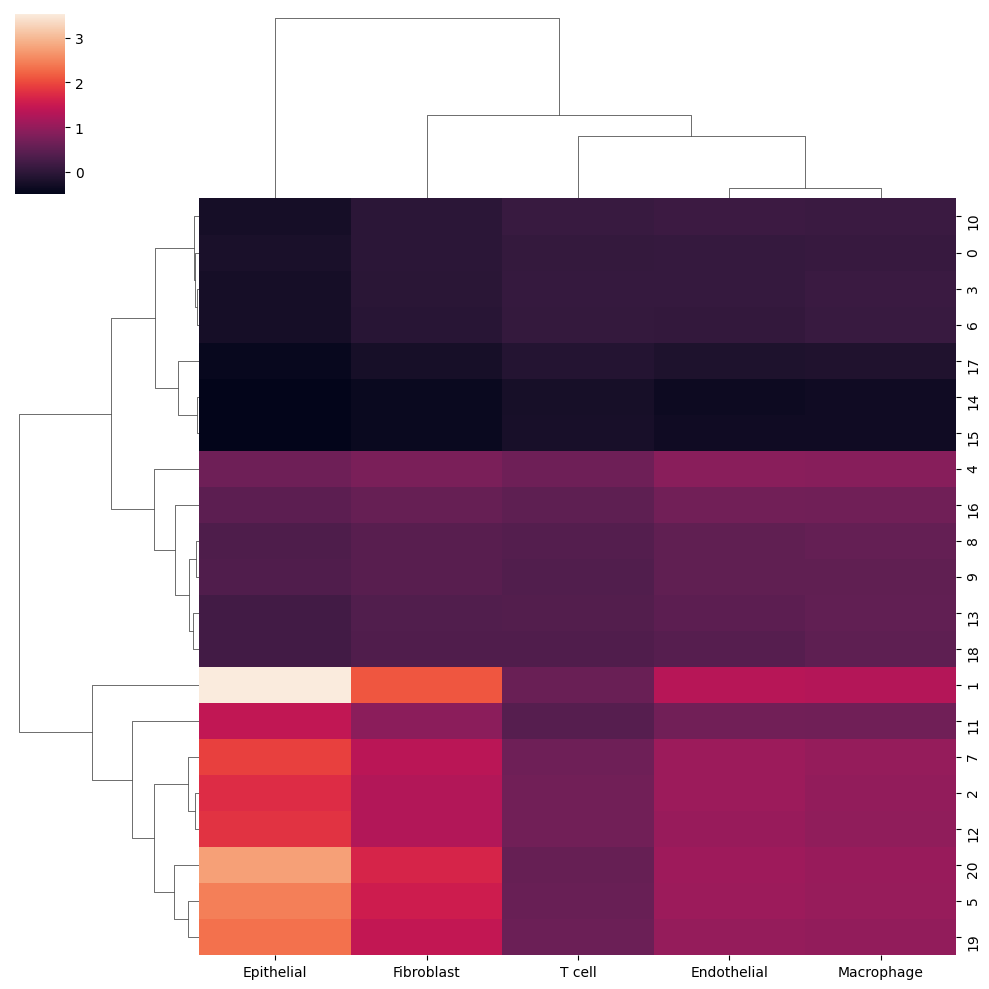

In [127]:
sns.clustermap(scored)

KeyError: 'Could not find key TME_boundary in .var_names or .obs.columns.'

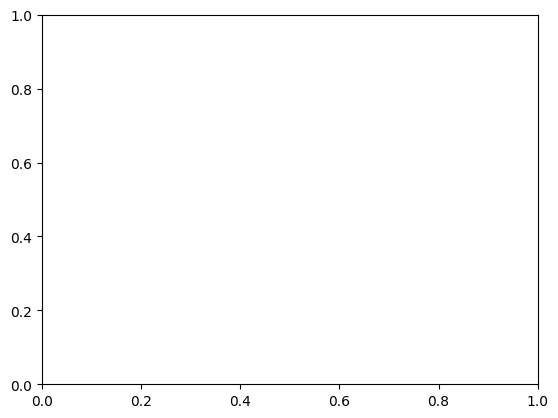

In [131]:
sc.pl.spatial(a, color=['TME_boundary'], alpha_img=0, vmax=2.)